In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

In [2]:
epochs = 10
batch_size = 32
learning_rate = 0.0001


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

train_dataset = datasets.ImageFolder('.././data/flower-photos/train', transform=transform_train)
val_dataset = datasets.ImageFolder('.././data/flower-photos/test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle=False)

In [5]:
print(len(train_dataset))
print(len(val_dataset))

3130
540


In [6]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [7]:
classes = ('daisy', 'dandelion', 'roses', 'sunflowers', 'tulips')


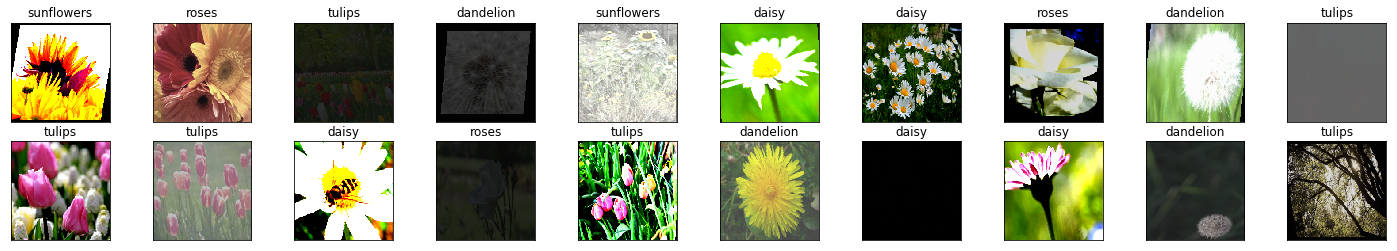

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [9]:
model = models.vgg16(pretrained=True)


In [10]:
print(model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [11]:
print(model.classifier[6].in_features) 
print(model.classifier[6].out_features)

4096
1000


In [12]:
for param in model.features.parameters():
  param.requires_grad = False

In [13]:
import torch.nn as nn

n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model.classifier[6].out_features)

5


In [15]:
print(model.classifier[6].in_features) 
print(model.classifier[6].out_features)

4096
5


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [17]:
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
class_total = list(0. for i in range(5))

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in val_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(train_loader.dataset)
    epoch_acc = running_corrects.float()/ len(train_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(val_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(val_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
    

    


epoch : 1
training loss: 0.0292, acc 0.6288 
validation loss: 0.0168, validation acc 0.8019 
epoch : 2
training loss: 0.0214, acc 0.7259 
validation loss: 0.0166, validation acc 0.8019 
epoch : 3
training loss: 0.0200, acc 0.7530 
validation loss: 0.0154, validation acc 0.8185 
epoch : 4
training loss: 0.0178, acc 0.7741 
validation loss: 0.0146, validation acc 0.8259 
epoch : 5
training loss: 0.0165, acc 0.7914 
validation loss: 0.0132, validation acc 0.8370 
epoch : 6
training loss: 0.0157, acc 0.8042 
validation loss: 0.0147, validation acc 0.8352 
epoch : 7
training loss: 0.0152, acc 0.8102 
validation loss: 0.0123, validation acc 0.8500 
epoch : 8
training loss: 0.0141, acc 0.8272 
validation loss: 0.0129, validation acc 0.8704 
epoch : 9
training loss: 0.0137, acc 0.8291 
validation loss: 0.0123, validation acc 0.8722 
epoch : 10
training loss: 0.0136, acc 0.8281 
validation loss: 0.0148, validation acc 0.8593 


In [18]:
#Predicting the Category for all Test Images
# Confusion_matrix

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([5,5], int)
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 540 test images: 86.30%


In [19]:
#class_wise accuracy
print('{0:5s} : {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:5s} : {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category : Accuracy
daisy : 90.2
dandelion : 91.7
roses : 75.8
sunflowers : 93.1
tulips : 79.8


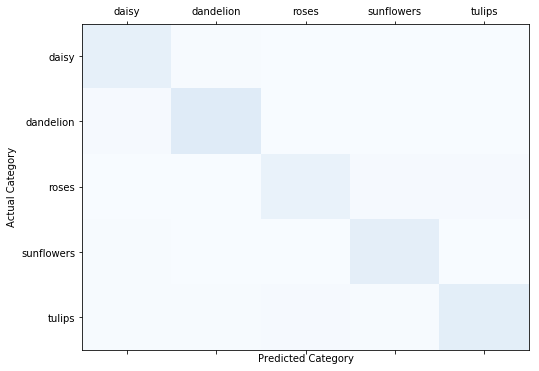

In [20]:
#plot confusion matrix

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(5), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(5), classes)
plt.show()


In [26]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()


actual/pred     daisy     dandelion roses     sunflowerstulips    
daisy           83        4         0         3         2         
dandelion       8         121       0         1         2         
roses           1         2         69        8         11        
sunflowers      5         1         0         94        1         
tulips          4         5         9         7         99        


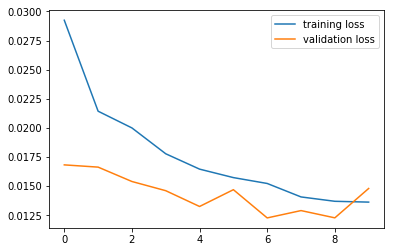

In [27]:
import seaborn as sns
sns.set()

plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

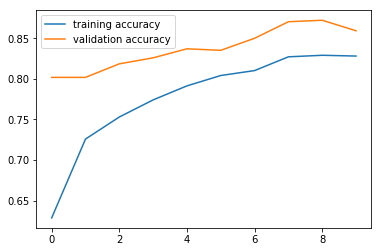

In [28]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [29]:
import PIL.ImageOps
import requests
from PIL import Image


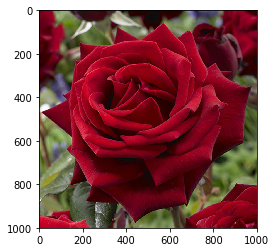

In [30]:
url = 'https://images.homedepot-static.com/productImages/e350ef76-f7ff-46ee-83d2-606aab23453c/svn/mea-nursery-rose-bushes-62014-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

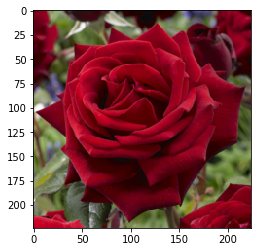

In [31]:
img = transform(img) 
plt.imshow(im_convert(img))

In [32]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

roses


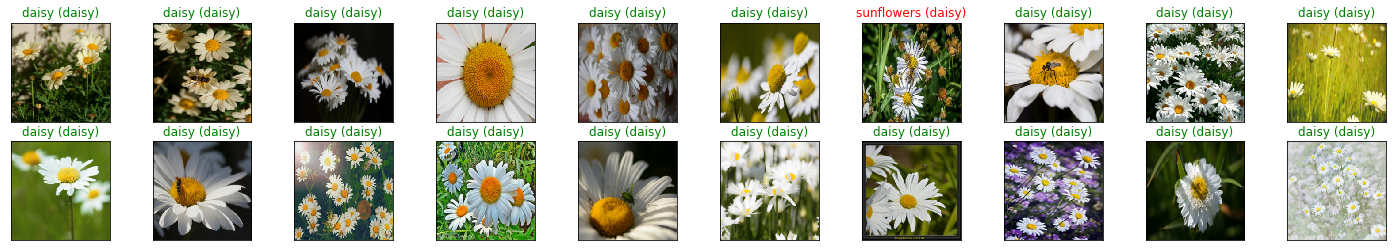

In [33]:
dataiter = iter(val_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))